In [1]:
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\win10\AppData\Local\Temp\ipykernel_2852\1060196020.py:16: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  gen['DATE_TIME'] = pd.to_datetime(gen['DATE_TIME'])



✅ Model saved as 'xgb_simple_model.pkl'

📉 Mean Squared Error (MSE): 16.01
🔍 R² Score: 0.9999


C:\Users\win10\AppData\Local\Temp\ipykernel_2852\1060196020.py:76: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\win10\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


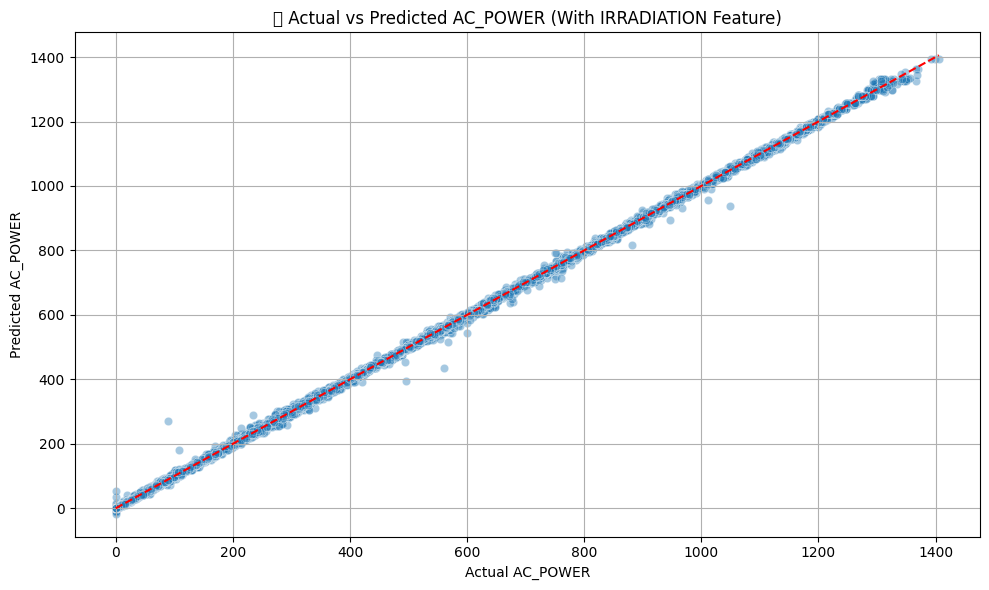

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# 📥 Load and merge function
def load_and_merge(gen_path, weather_path):
    gen = pd.read_csv(gen_path)
    weather = pd.read_csv(weather_path)

    gen['DATE_TIME'] = pd.to_datetime(gen['DATE_TIME'])
    weather['DATE_TIME'] = pd.to_datetime(weather['DATE_TIME'])

    # Merge and rename columns for clarity
    merged = pd.merge(gen, weather, on='DATE_TIME', suffixes=('_gen', '_weather'))
    merged.rename(columns={'DC_POWER': 'DC_POWER', 'IRRADIATION': 'IRRADIATION'}, inplace=True)
    return merged

# 📊 Load both plants
plant1 = load_and_merge('data/Plant_1_Generation_Data.csv', 'data/Plant_1_Weather_Sensor_Data.csv')
plant2 = load_and_merge('data/Plant_2_Generation_Data.csv', 'data/Plant_2_Weather_Sensor_Data.csv')

# 🧬 Combine and clean
df = pd.concat([plant1, plant2], ignore_index=True)
df.dropna(subset=['DC_POWER', 'IRRADIATION', 'AC_POWER'], inplace=True)

# 🕒 Extract simple time features
df['hour'] = df['DATE_TIME'].dt.hour
df['dayofweek'] = df['DATE_TIME'].dt.dayofweek

# 🎯 Features (with IRRADIATION) and target
features = ['hour', 'dayofweek', 'DC_POWER', 'IRRADIATION']
target = 'AC_POWER'

X = df[features]
y = df[target]

# 🧪 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔧 Model training
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
model.fit(X_train, y_train)

# 💾 Save model
joblib.dump(model, 'xgb_simple_model.pkl')
print("\n✅ Model saved as 'xgb_simple_model.pkl'")

# 📈 Predictions
y_pred = model.predict(X_test)

# 📊 Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\n📉 Mean Squared Error (MSE): {mse:.2f}")
print(f"🔍 R² Score: {r2:.4f}")

# 📈 Plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual AC_POWER")
plt.ylabel("Predicted AC_POWER")
plt.title("🔍 Actual vs Predicted AC_POWER (With IRRADIATION Feature)")
plt.grid(True)
plt.tight_layout()
plt.show()


